# Kafka and Spark Streaming Exercise

**INFORMATION**: This exercise is easier on the cluster!

Kafka is an excellent tool for data engineering projects due to its distributed, fault-tolerant, and scalable architecture, which facilitates real-time data streaming and processing. It serves as a highly reliable messaging system that efficiently handles large volumes of data streams from diverse sources. Kafka's ability to decouple data producers from consumers and its support for parallel data processing make it ideal for building robust and scalable data pipelines. Additionally, Kafka's durability and fault-tolerance ensure that data is safely persisted and replicated across nodes, minimizing the risk of data loss and ensuring continuous data availability for downstream applications and analytics.

Spark Streaming enables the real-time processing of data streams with high throughput and low latency. It seamlessly integrates with Apache Spark's core APIs, allowing developers to leverage Spark's powerful data processing capabilities for streaming data. Spark Streaming supports a wide range of data sources, including Kafka, Flume, and HDFS, and can process data in near real-time, making it ideal for applications that require instant insights and timely responses.

Use Python, ```pyspark```, ```pandas```, ```confluent-kafka``` and/or ```kafka-python``` to send messages to a Kafka topic and analyse them with Spark Streaming:

# Kafka Streaming mit Musikdaten (Top 100 gestreamte Songs)

In diesem Notebook wird gezeigt, wie man mit Apache Kafka und Spark Streaming Daten in Echtzeit verarbeitet. Als Datenquelle verwenden wir eine CSV-Datei mit den 100 meistgestreamten Songs, z. B. basierend auf Spotify-Statistiken.

Ziel:
- Die Songs werden per Kafka Producer an ein Kafka Topic gesendet.
- Spark Structured Streaming liest dieses Topic aus, verarbeitet die Daten und visualisiert z. B. die beliebtesten Künstler.

# Kafka

In [1]:
import os
import sys
from pyspark.sql import SparkSession
os.environ["JAVA_HOME"] = "C:\\Program Files\\Eclipse Adoptium\\jdk-11.0.27.6-hotspot"
os.environ["PYSPARK_PYTHON"] = sys.executable

## Import Necessary Libraries

In [2]:
 # TODO
!pip install kafka-python
!pip install confluent-kafka
!pip install pyspark

## Load a dataset to stream
Select a suitable dataset from previous exercises and split it into individual JSON messages.

In [3]:
# TODO
import pandas as pd
import json
df = pd.read_csv(
    "Top_100_most_Streamed.csv")
df.columns = [col.replace('.', '_') for col in df.columns]
df["year"] = df["year"].astype(str)
df["length"] = df["length"].astype(str)
json_messages = df.to_dict(orient="records")


## Create a producer and stream the messages
You need to use a Kafka producer to connect to a broker and send the messages to a topic.

In [4]:
# TODO
import pandas as pd
import json
from kafka import KafkaProducer
import time

df = pd.read_csv(
    "Top_100_most_Streamed.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(".", "_").str.replace(" ", "_")
json_messages = df.to_dict(orient="records")
producer = KafkaProducer(bootstrap_servers='172.29.16.102:9092')

for msg in json_messages:
    message = json.dumps(msg).encode("utf-8")
    producer.send("music_data", message)
    print(f"Gesendet: {msg.get('title', '??')} von {msg.get('artist', '??')}")
    time.sleep(0.5)
producer.flush()
print("Alle Songs erfolgreich gesendet.")

NoBrokersAvailable: NoBrokersAvailable

## Create a consumer and check if the messages can be read
A Kafka consumer can subscribe to one or more topics and process the messages. Display the messages from the previous step.

In [8]:
# TODO
from kafka import KafkaConsumer
import json
consumer = KafkaConsumer(
    'music_data',
    bootstrap_servers='localhost:9092',
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id='music_consumer_group',
    value_deserializer=lambda x: json.loads(x.decode('utf-8')),
        consumer_timeout_ms=60000
)
import time
start_time = time.time()
max_duration = 1 * 60
print("Starte Kafka Consumer...\n")
for message in consumer:
    song = message.value
    print(f"Empfangen: {song.get('title', '??')}")
    print(f"von {song.get('artist', '??')}")
    if time.time() - start_time > max_duration:
        print("\n1 Minuten erreicht. Consumer wird beendet.")
        break
consumer.close()

Starte Kafka Consumer...

Empfangen: Blinding Lights
von The Weeknd
Empfangen: Watermelon Sugar
von Harry Styles
Empfangen: Mood (feat. iann dior)
von 24kGoldn
Empfangen: Someone You Loved
von Lewis Capaldi
Empfangen: Perfect
von Ed Sheeran
Empfangen: Believer
von Imagine Dragons
Empfangen: lovely (with Khalid)
von Billie Eilish
Empfangen: Circles
von Post Malone
Empfangen: Shape of You
von Ed Sheeran
Empfangen: Memories
von Maroon 5
Empfangen: Closer
von The Chainsmokers
Empfangen: bad guy
von Billie Eilish
Empfangen: Say You Won't Let Go
von James Arthur
Empfangen: Lucid Dreams
von Juice WRLD
Empfangen: All of Me
von John Legend
Empfangen: 7 rings
von Ariana Grande
Empfangen: Jocelyn Flores
von XXXTENTACION
Empfangen: goosebumps
von Travis Scott
Empfangen: Wake Me Up
von Avicii
Empfangen: ROCKSTAR (feat. Roddy Ricch)
von DaBaby
Empfangen: rockstar (feat. 21 Savage)
von Post Malone
Empfangen: Photograph
von Ed Sheeran
Empfangen: SAD!
von XXXTENTACION
Empfangen: SICKO MODE
von Travis S

# Kafka and Spark Streaming
Spark can act as a Kafka consumer. This gives you the benefits of the Spark framework to process the Kafka messages. 

## Spark Context and Session

Initialize Spark Context and Spark Session

In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
spark = SparkSession.builder \
    .appName("My PySpark App") \
.master("spark://172.29.16.102:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.4.2") \
    .getOrCreate()

## Create a Spark DataFrame from a Kafka stream

In [ ]:
import json
from kafka import KafkaConsumer
from pyspark.sql import SparkSession, Row

consumer = KafkaConsumer(
    'music_data',
    bootstrap_servers='localhost:9092',
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    value_deserializer=lambda m: json.loads(m.decode('utf-8')),
    consumer_timeout_ms=2000
)

messages = [msg.value for msg in consumer if isinstance(msg.value, dict)]
consumer.close()

EXPECTED_KEYS = ["artist", "title", "year", "top_genre", "popularity"]

rows = []
for i, msg in enumerate(messages):
    try:
        clean_msg = {key: msg.get(key, None) for key in EXPECTED_KEYS}
        rows.append(Row(**clean_msg))
    except Exception as e:
        print(f"[{i}] Fehler bei Nachricht: {msg}\n{e}")

if rows:
    df = spark.createDataFrame(rows)
    df.show(truncate=False)
    df.printSchema()
else:
    print("Keine gültigen Daten empfangen.")


## Convert the binary Kafka data to strings

In [11]:
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

df_raw = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "music_data") \
    .option("startingOffsets", "earliest") \
    .load()

df_strings = df_raw.select(col("value").cast("string").alias("value_str"))

query = df_strings.writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

time.sleep(10)
query.stop()


## Create a structured schema for the streamed data

Use objects like ```StructType```, ```StructField```, ```IntegerType```, ```BooleanType```, etc to create the schema. Afterwards apply the schema to the DataFrame.

In [15]:
# TODO
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, BooleanType

schema = StructType([
    StructField("title", IntegerType()),
    StructField("artist", StringType()),
    StructField("duration", IntegerType()),
    StructField("explicit", BooleanType())
])
from pyspark.sql.functions import col, from_json

df_kafka_raw = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "music_data") \
    .load()

df_parsed = df_kafka_raw.selectExpr("CAST(value AS STRING) as json_str") \
    .select(from_json(col("json_str"), schema).alias("data")) \
    .select("data.*")

## Create a DataFrame grouped by a time window
E.g., the number of messages of the different types over the last minute.

In [16]:
from pyspark.sql.functions import from_json, col, window
from pyspark.sql.types import StructType, StringType, IntegerType, BooleanType
import time

schema = StructType() \
    .add("title", StringType()) \
    .add("artist", StringType()) \
    .add("duration", IntegerType()) \
    .add("explicit", BooleanType())

df_parsed = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "music_data") \
    .option("startingOffsets", "earliest") \
    .load() \
    .selectExpr("CAST(value AS STRING)", "timestamp") \
    .select(from_json(col("value"), schema).alias("data"), col("timestamp")) \
    .select("data.*", "timestamp")

df_windowed = df_parsed \
    .withWatermark("timestamp", "1 minute") \
    .groupBy(window(col("timestamp"), "1 minute"), col("artist")) \
    .count()

query = df_windowed.writeStream \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", False) \
    .option("checkpointLocation", "file:///C:/Users/pinar/tmp/spark-window-checkpoint") \
    .start()

time.sleep(20)
query.stop()

## Create a query stream of the DataFrame
Write the output of the DataFrame to a memory sink of your choice. Use the ```start()``` method to actually start the stream processing.

In [18]:
import time
from pyspark.sql.functions import col, from_json
from pyspark.sql.types import StructType, StructField, StringType, BooleanType

schema = StructType([
    StructField("title", StringType()),
    StructField("artist", StringType()),
])

df_raw = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "music_data") \
    .option("startingOffsets", "earliest") \
    .load()

df_strings = df_raw.selectExpr("CAST(value AS STRING)")

df_parsed = df_strings \
    .select(from_json(col("value"), schema).alias("data")) \
    .select("data.*")

query = df_parsed.writeStream \
    .format("memory") \
    .outputMode("append") \
    .queryName("messages_table") \
    .start()

time.sleep(10)
query.stop()

spark.sql("SELECT * FROM messages_table").show(truncate=False)


+----------------------------+----------------+
|title                       |artist          |
+----------------------------+----------------+
|Blinding Lights             |The Weeknd      |
|Watermelon Sugar            |Harry Styles    |
|Mood (feat. iann dior)      |24kGoldn        |
|Someone You Loved           |Lewis Capaldi   |
|Perfect                     |Ed Sheeran      |
|Believer                    |Imagine Dragons |
|lovely (with Khalid)        |Billie Eilish   |
|Circles                     |Post Malone     |
|Shape of You                |Ed Sheeran      |
|Memories                    |Maroon 5        |
|Closer                      |The Chainsmokers|
|bad guy                     |Billie Eilish   |
|Say You Won't Let Go        |James Arthur    |
|Lucid Dreams                |Juice WRLD      |
|All of Me                   |John Legend     |
|7 rings                     |Ariana Grande   |
|Jocelyn Flores              |XXXTENTACION    |
|goosebumps                  |Travis Sco

## Export the processed data as a Pandas DataFrame and visualize it

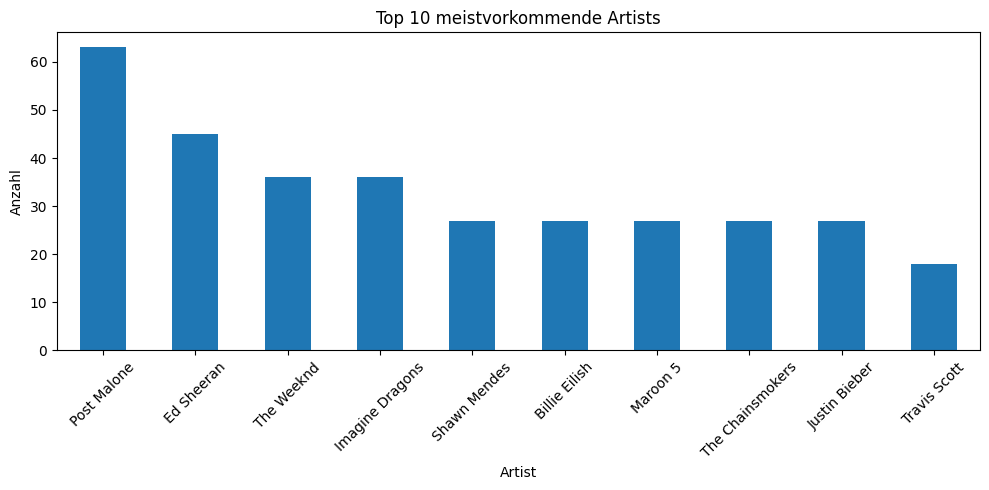

In [19]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType

schema = StructType([
    StructField("title", StringType()),
    StructField("artist", StringType()),
    StructField("duration", IntegerType()),
    StructField("explicit", BooleanType())
])

df_raw = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "music_data") \
    .option("startingOffsets", "earliest") \
    .load()

df_parsed = df_raw.selectExpr("CAST(value AS STRING)") \
    .select(from_json(col("value"), schema).alias("data")) \
    .select("data.*")

query = df_parsed.writeStream \
    .format("memory") \
    .queryName("songs_table") \
    .outputMode("append") \
    .start()

time.sleep(10)
query.stop()

df_spark = spark.sql("SELECT * FROM songs_table")
df_pandas = df_spark.toPandas()

df_grouped = df_pandas["artist"].value_counts().head(10)

plt.figure(figsize=(10, 5))
df_grouped.plot(kind="bar")
plt.title("Top 10 meistvorkommende Artists")
plt.xlabel("Artist")
plt.ylabel("Anzahl")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
print(spark.version)
print(spark.sparkContext.master)


NameError: name 'spark' is not defined

In [4]:
spark.stop()

NameError: name 'spark' is not defined